### Тематическое моделирование базы телефонных звонков при помощи латентного размещения Дирихле (LDA)

In [1]:
import os
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
import spacy
import pandas as pd
import numpy as np
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
from multiprocessing import Process, Lock
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow_hub as hub
import tensorflow_text
warnings.filterwarnings('ignore')

/home/uadmin/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
TRANSCRIBE_PATH = "normalized_recognition"


In [5]:
data_words = []
data_strings = []
file_names = []

for folder in os.listdir(TRANSCRIBE_PATH):
    if not folder.startswith("."):
        print("folder: " + folder)
        folder_path = TRANSCRIBE_PATH + '/' + folder
        for text_name in os.listdir(folder_path):
            text_path = folder_path + '/' + text_name
            f = open(text_path, 'r')
            words = f.read()
            if words:
                split = words.split()
                if len(split) > 100:
                    data_words.append(split)
                    data_strings.append(words)
                    file_names.append(text_name)

folder: 1579
folder: 1564
folder: 1541
folder: 1604
folder: 1601
folder: 1581
folder: 1573
folder: 1554
folder: 1600
folder: 1597
folder: 1569
folder: 1552
folder: 1585
folder: 1558
folder: 1575
folder: 1546
folder: 1588
folder: 1565
folder: 1570
folder: 1598
folder: 1578
folder: 1567
folder: 1584
folder: 1599
folder: 1547
folder: 1592
folder: 1595
folder: 1571
folder: 1596
folder: 1553
folder: 1572
folder: 1568
folder: 1605
folder: 1582
folder: 1566
folder: 1576
folder: 1591
folder: 1590
folder: 1563
folder: 1549
folder: 1555
folder: 1589
folder: 1557
folder: 1545
folder: 1593
folder: 1550
folder: 1543
folder: 1602
folder: 1603
folder: 1583
folder: 1542
folder: 1577
folder: 1548
folder: 1587
folder: 1561
folder: 1544
folder: 1580
folder: 1594
folder: 1586
folder: 1574
folder: 1551
folder: 1562
folder: 1556


In [90]:
# Общее количество записей
len(file_names)

62072

In [95]:
doc_lens = [len(d) for d in data_strings]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(data_strings, bins = 1000, color='navy')


plt.gca().set(xlim=(0, 1000), ylabel='Количество документов', xlabel='Количество слов')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Распределение документов по количеству слов', fontdict={'size': 22})
plt.show()

ValueError: Image size of 86634x1021 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2560x1120 with 1 Axes>

Исправляем часто встречающиеся ошибки распознавания

In [7]:
for j, text in enumerate(data_words):
    for i, word in enumerate(data_words[j]):
        if word in ('диадох', 'виадук'):
            data_words[j][i] = 'диадок'

## Лемматизация

In [ ]:
nlp = spacy.load('ru_core_news_sm', disable=['parser', 'ner'])

In [ ]:
def lemmatization(texts, lock):
    output = []
    try:
        lock.acquire()
        print('lemmatization started. len=', len(texts))
    finally:
        lock.release()
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    for text in texts:
        doc = nlp(" ".join(text)) 
        output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    with open("data_lemmatized.txt", "a") as txt_file:
        for line in output:
            txt_file.write(" ".join(line) + "\n")

In [ ]:
# Распараллеливание вычислений на несколько ядер CPU
with open("data_lemmatized.txt", "a") as txt_file:
    txt_file.truncate(0)
    
length = len(data_words)
ranges = np.linspace(0, length, os.cpu_count())
if __name__ == '__main__':
    processes = []
    lock = Lock()

    p1 = multiprocessing.Process(target=lemmatization, args=(data_words[:int(ranges[1])], lock))
    processes.append(p1)
    p1.start()
    print('Process 1 started.')
    
    p2 = multiprocessing.Process(target=lemmatization, args=(data_words[int(ranges[1]):int(ranges[2])], lock))
    processes.append(p2)
    p2.start()
    print('Process 2 started.')
    
    p3 = multiprocessing.Process(target=lemmatization, args=(data_words[int(ranges[2]):int(ranges[3])], lock))
    processes.append(p3)
    p3.start()
    print('Process 3 started.')
    
    p4 = multiprocessing.Process(target=lemmatization, args=(data_words[int(ranges[3]):int(ranges[4])], lock))
    processes.append(p4)
    p4.start()
    print('Process 4 started.')
    
    p5 = multiprocessing.Process(target=lemmatization, args=(data_words[int(ranges[4]):int(ranges[5])], lock))
    processes.append(p5)
    p5.start()
    print('Process 5 started.')
    
    p6 = multiprocessing.Process(target=lemmatization, args=(data_words[int(ranges[5]):int(ranges[6])], lock))
    processes.append(p6)
    p6.start()
    print('Process 6 started.')
    
    p7 = multiprocessing.Process(target=lemmatization, args=(data_words[int(ranges[6]):], lock))
    processes.append(p7)
    p7.start()
    print('Process 7 started.')
    
    
    for process in processes:
        process.join()


In [ ]:
# Сохранение результатов в файл
# with open("data_lemmatized.txt", "w") as txt_file:
#     for line in data_lemmatized:
#         txt_file.write(" ".join(line) + "\n") 

In [8]:
# Считывание ранее преобразованного корпуса из сохраненного файла
data_lemmatized2 = []
with open("data_lemmatized.txt", "r") as txt_file:
    for line in txt_file:
        data_lemmatized2.append(line.split(' ')) 

### Обход лемматизации

Используется в случае встраивания лемматизации в алгоритм распознавания аудио

In [9]:
data_lemmatized2 = data_words_trigrams

NameError: name 'data_words_trigrams' is not defined

## Формирование корпуса, включающего биграммы и триграммы

Часто встречающиеся соседние слова объединяются в единую лексему с разделителем _

In [10]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)

In [11]:
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [12]:
# Слова и биграммы в одном из документов
bigram_mod[data_words[2]]

['спасибо',
 'пятнадцать',
 'восемьдесят',
 'ноль',
 'семь',
 'евгений',
 'оставлять',
 'евгений',
 'евгений',
 'добрый',
 'день',
 'максим',
 'максим',
 'здравствуйте',
 'подсказать',
 'пожалуйста',
 'обновление',
 'контур',
 'экстерн',
 'лайта',
 'баланс',
 'глава',
 'удаваться',
 'проверить',
 'документ',
 'спешить',
 'использование',
 'кэйт',
 'эклектичность',
 'инициализация',
 'ошибка',
 'нужный',
 'ваш',
 'электронный',
 'почта',
 'наш',
 'сайт',
 'нужно',
 'обновить',
 'это',
 'ошибка',
 'немножко',
 'другой',
 'версия',
 'определённый',
 'версия',
 'понять',
 'ой',
 'тот',
 'женщина',
 'бабочка',
 'который',
 'собака',
 'би',
 'дефис',
 'френд',
 'точка_ру',
 'бенефис',
 'далёкий',
 'френд',
 'друг',
 'точка_ру',
 'прийти',
 'утро',
 'обновление',
 'побыть',
 'сразу',
 'правительство',
 'группа',
 'неправильно',
 'другой',
 'прислать',
 'свой',
 'место',
 'ще',
 'момент',
 'давать',
 'другой',
 'точка',
 'собака',
 'точка_ру',
 'часто',
 'минутка',
 'просить',
 'гм_гм',
 'нали

In [13]:
# Список найденных биграмм
bigram_mod.phrasegrams

{'набрать_тоновый': 336.43186101413744,
 'тоновый_режим': 360.3304644510418,
 'режим_соединять': 169.5239168713365,
 'соединять_сотрудник': 121.0424525979948,
 'ожидать_соединение': 316.957765587285,
 'налог_имущество': 206.11332538879708,
 'отчётный_период': 286.4326317512729,
 'индивидуальный_предприниматель': 3595.978700971325,
 'перед_я': 378.1731595351844,
 'авансовый_платёж': 1062.1274013483721,
 'помощь_дистанционный': 125.38161455802155,
 'дистанционный_помощь': 269.10879481203267,
 'четвёртый_квартал': 106.44750523182901,
 'кантин_июль': 110.48955472326259,
 'центр_электромонтаж': 168.71946600781874,
 'фёдор_фёдор': 232.0724899481382,
 'английский_буква': 127.31845933470542,
 'б_б': 112.74952206972435,
 'собака_отжимать': 308.4772859300569,
 'дабла_ю': 4864.718358311646,
 'повторный_попытка': 234.04639877246072,
 'повторить_попытка': 221.12285882781936,
 'точка_ру': 232.08289494181687,
 'гм_гм': 103.91453762551049,
 'погодить_погодить': 391.9343820496904,
 'спасский_ворота': 4

Аналогично формируем триграммы

In [14]:
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) 

In [15]:
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [16]:
# Список найденных биграмм и триграмм
trigram_mod.phrasegrams

{'набрать_тоновый': 135031.23236763236,
 'сотрудник_набрать_тоновый': 27643.091359151855,
 'режим_соединять': 4331.219549391207,
 'набрать_тоновый_режим_соединять': 4630.786268378293,
 'ожидать_соединение': 8644.541141426924,
 'пожалуйста_ожидать_соединение': 284.73304521856505,
 'налог_имущество': 520.4120252829789,
 'отчётный_период': 736.1771099009161,
 'индивидуальный_предприниматель': 33529.043038642456,
 'перед_я': 3111.6805158118714,
 'авансовый_платёж': 3142.1582340095247,
 'помощь_дистанционный': 879.4779404616972,
 'помощь_помощь_дистанционный': 101.40919109405284,
 'система_налогообложение': 114.05350950224135,
 'четвёртый_квартал': 175.56912078765038,
 'кантин_июль': 229.24111053463483,
 'центр_электромонтаж': 1716.9963224750754,
 'фёдор_фёдор': 269.1039064049177,
 'английский_буква': 192.2660103010908,
 'б_б': 121.42590132618128,
 'кол_центр': 160.961029818282,
 'крайний_случай': 131.8422304955276,
 'собака_отжимать': 1168.6319175341287,
 'дабла_ю': 131029.47586206897,
 'п

In [17]:
# Пример формирования триграмм в одном документе
trigram_mod[bigram_mod[data_words[2]]]

['спасибо',
 'пятнадцать',
 'восемьдесят',
 'ноль',
 'семь',
 'евгений',
 'оставлять',
 'евгений',
 'евгений',
 'добрый',
 'день',
 'максим',
 'максим',
 'здравствуйте',
 'подсказать',
 'пожалуйста',
 'обновление',
 'контур',
 'экстерн',
 'лайта',
 'баланс',
 'глава',
 'удаваться',
 'проверить',
 'документ',
 'спешить',
 'использование',
 'кэйт',
 'эклектичность',
 'инициализация',
 'ошибка',
 'нужный',
 'ваш',
 'электронный',
 'почта',
 'наш',
 'сайт',
 'нужно',
 'обновить',
 'это',
 'ошибка',
 'немножко',
 'другой',
 'версия',
 'определённый',
 'версия',
 'понять',
 'ой',
 'тот',
 'женщина',
 'бабочка',
 'который',
 'собака',
 'би',
 'дефис',
 'френд',
 'точка_ру',
 'бенефис',
 'далёкий',
 'френд',
 'друг',
 'точка_ру',
 'прийти',
 'утро',
 'обновление',
 'побыть',
 'сразу',
 'правительство',
 'группа',
 'неправильно',
 'другой',
 'прислать',
 'свой',
 'место',
 'ще',
 'момент',
 'давать',
 'другой',
 'точка',
 'собака_точка_ру',
 'часто',
 'минутка',
 'просить',
 'гм_гм',
 'налить',

Формируем биграммы и триграммы в каждом документе

In [18]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [19]:
data_words_bigrams = make_bigrams(data_words)

In [20]:
data_words_trigrams = make_trigrams(data_words)

### Формирование корпуса

In [21]:
# Формирование словаря - отображение слов на их ID
id2word = corpora.Dictionary(data_lemmatized2)
id2word.filter_extremes(no_below=2, no_above=1.0)

# Формирование модели Bag of words без TF-IDF
# [(id слова, кол-во в документе), (), ()...]
corpus = [id2word.doc2bow(text) for text in data_lemmatized2]

In [22]:
# Bag of words 0-го документа
corpus[0]

[(0, 1),
 (1, 2),
 (2, 1),
 (3, 1),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 2),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 2),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 2),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 2),
 (49, 1),
 (50, 2),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 2),
 (79, 1),
 (80, 1)]

In [95]:
# Сохранение корпуса в файл
with open('corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [96]:
# with open("corpus.pkl", "rb") as file_to_read:
#     corpus = pickle.load(file_to_read)

### Визуализация распределения документов по количеству слов

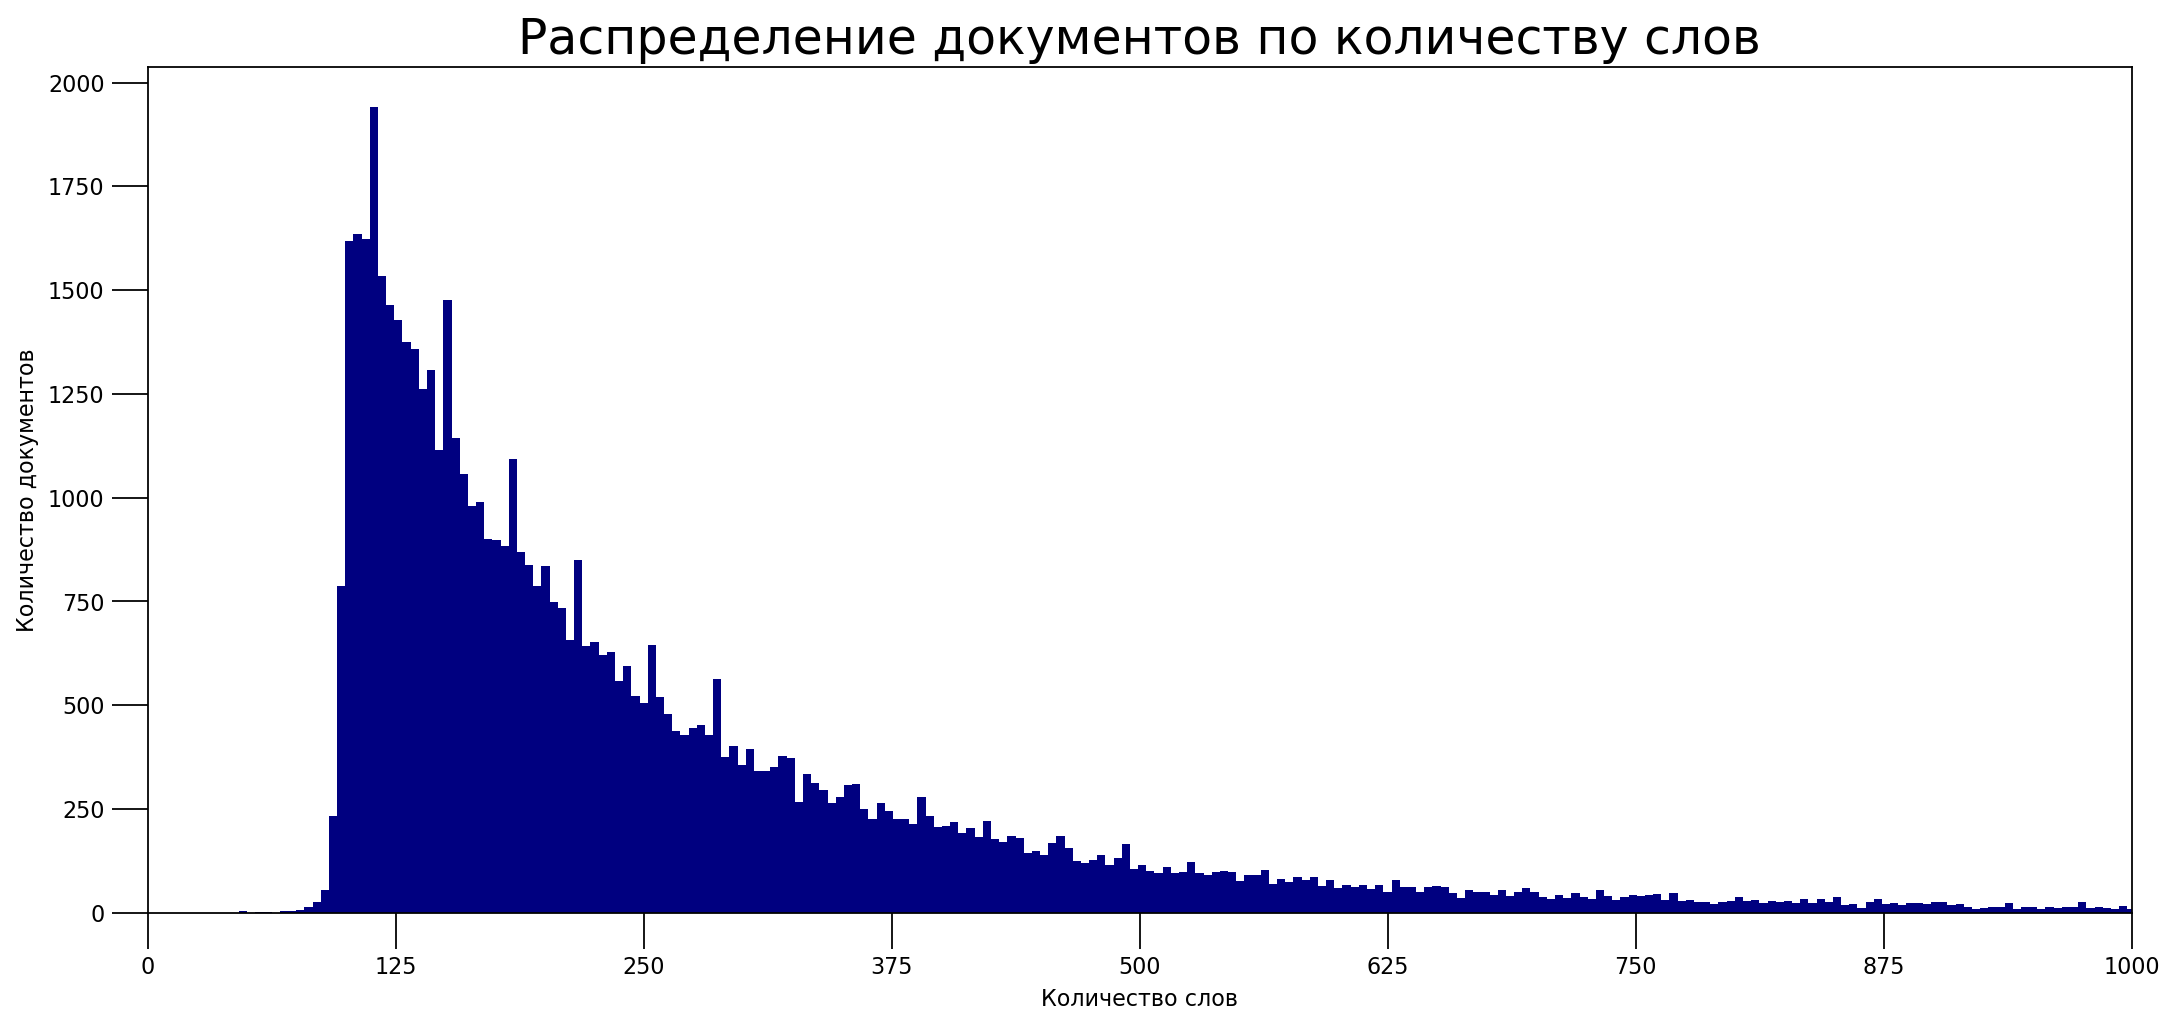

In [97]:
doc_lens = [len(d) for d in data_lemmatized2]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')


plt.gca().set(xlim=(0, 1000), ylabel='Количество документов', xlabel='Количество слов')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Распределение документов по количеству слов', fontdict={'size': 22})
plt.show()

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

## TF-IDF преобразование

In [23]:
from gensim.models.tfidfmodel import TfidfModel

In [24]:
tf_idf = gensim.models.tfidfmodel.TfidfModel(corpus=corpus, id2word=id2word, smartirs='afx')

In [25]:
# Формирование корпуса после преобразования TF-IDF
# [(id слова, нормированная частота в документе), (), ()...]
corpus_tfidf = [tf_idf[text] for text in corpus]

In [26]:
# Пример
corpus_tfidf[0]

[(0, 3.1052214729452947),
 (1, 4.547158865093537),
 (2, 4.485455553333354),
 (3, 5.243188254916625),
 (4, 3.4052162761771054),
 (5, 0.6882405419308921),
 (6, 5.29310164959808),
 (7, 5.413313578005292),
 (8, 4.573715828054114),
 (9, 3.9309716154535055),
 (10, 7.64530091716639),
 (11, 4.746898480137729),
 (12, 5.073231056566658),
 (13, 0.8332372269362874),
 (14, 3.9062013718860173),
 (15, 3.243400186496613),
 (16, 0.9021810756629922),
 (17, 0.8569519382676651),
 (18, 3.805360991365755),
 (19, 3.2397577839988183),
 (20, 2.8808779152881137),
 (21, 6.052429477026747),
 (22, 2.91798232751051),
 (23, 5.669783427787359),
 (24, 8.458349115757747),
 (25, 5.516700729460471),
 (26, 2.378682111068403),
 (27, 5.210430315734644),
 (28, 4.261542361151947),
 (29, 2.007188144891043),
 (30, 4.457208413759022),
 (31, 6.275299619330562),
 (32, 2.3136117382772525),
 (33, 4.304445493035393),
 (34, 2.064854684698059),
 (35, 2.1942834322650757),
 (36, 7.761783674006664),
 (37, 4.175554221629859),
 (38, 1.90782

## Построение модели LDA 

Используется корпус после преобразования TF-IDF и словарь id2word для восстановления исходных слов по их id

In [54]:
lda_model_tfidf = LdaMulticore(corpus=corpus_tfidf,
                        id2word=id2word,
                        num_topics=12, 
                        random_state=100,
                        chunksize=1000,
                        passes=4,
                        batch=False,
                        alpha='asymmetric',
                        eta=None,
                        decay=0.8,
                        offset=1.0,
                        eval_every=10,
                        iterations=70,
                        gamma_threshold=0.002,
                        minimum_probability=0.01,
                        minimum_phi_value=0.01,
                        per_word_topics=False)

Выведем наиболее частые слова каждой темы

In [42]:
lda_model_tfidf.show_topics()

[(11,
  '0.001*"договор" + 0.001*"компания" + 0.001*"очень" + 0.001*"работать" + 0.001*"тысяча" + 0.001*"понимать" + 0.001*"информация" + 0.001*"стоить" + 0.001*"уточнить" + 0.001*"говорить"'),
 (10,
  '0.001*"компьютер" + 0.001*"установить" + 0.001*"пароль" + 0.001*"нажать" + 0.001*"сертификат" + 0.001*"браузер" + 0.001*"войти" + 0.001*"кнопка" + 0.001*"попробовать" + 0.001*"сотрудник"'),
 (9,
  '0.001*"сертификат" + 0.001*"ключ" + 0.001*"номер" + 0.001*"подсказать" + 0.001*"семьдесят" + 0.001*"новый" + 0.001*"нажать" + 0.001*"ноль" + 0.001*"заявление" + 0.001*"телефон"'),
 (8,
  '0.001*"написать" + 0.001*"почта" + 0.001*"ладный" + 0.001*"добрый" + 0.001*"вообще" + 0.001*"большой" + 0.001*"компания" + 0.001*"счёт" + 0.001*"письмо" + 0.001*"сотрудник"'),
 (7,
  '0.002*"компьютер" + 0.001*"установить" + 0.001*"программа" + 0.001*"баланс" + 0.001*"файл" + 0.001*"ключ" + 0.001*"скачать" + 0.001*"ноль" + 0.001*"попробовать" + 0.001*"установка"'),
 (4,
  '0.001*"заявление" + 0.001*"сертифик

Выберем модовую тему каждой записи, используем ее для визуализации t-SNE

In [55]:
max_topics = [max(map(lambda x: x[0], lda_model_tfidf.get_document_topics(corpus[i]) )) for i, _ in enumerate(corpus)]

In [56]:
len(max_topics)

62072

In [57]:
text_topic_mapping = pd.DataFrame({"file_name": file_names, "topic": max_topics})

In [58]:
text_topic_mapping

,file_name,topic
0,1579769179.72238.txt,4
1,1579534063.62363.txt,0
2,1579509983.59048.txt,11
3,1579088437.47050.txt,8
4,1579161966.49942.txt,8
...,...,...
62067,1556196307.242144.txt,7
62068,1556621827.252476.txt,5
62069,1556288216.247176.txt,7
62070,1556283861.246650.txt,9


In [59]:
# Сохраняем соответствие тем и записей в файл
with open('text_topic_mapping_12.pkl', 'wb') as f:
    pickle.dump(text_topic_mapping, f)

## Визуализация

In [60]:
vis_data = gensimvis.prepare(lda_model_tfidf, corpus_tfidf, id2word)

In [89]:
pyLDAvis.display(vis_data)

In [33]:
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, corpus=corpus_tfidf, texts=data_lemmatized2, dictionary=id2word, coherence='c_v', topn=15)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.42837690045187615


In [34]:
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))


Perplexity:  -9.595415460772509


## Подбор оптимального количества тем

Grid Search для гиперпараметра num_topics

In [35]:
num_topics_array = np.arange(4,13,1)
coherence_scores, perplexities, topics = {}, {}, []

In [36]:
for num_topics in num_topics_array:
    lda_model_tfidf = LdaMulticore(corpus=corpus_tfidf,
                        id2word=id2word,
                        num_topics=num_topics, 
                        random_state=100,
                        chunksize=1000,
                        passes=4,
                        batch=False,
                        alpha='asymmetric',
                        eta=None,
                        decay=0.8,
                        offset=1.0,
                        eval_every=10,
                        iterations=70,
                        gamma_threshold=0.002,
                        minimum_probability=0.01,
                        minimum_phi_value=0.01,
                        per_word_topics=False)
    coherence_model_lda = CoherenceModel(model=lda_model_tfidf, 
                                         corpus=corpus_tfidf, 
                                         texts=data_lemmatized2, 
                                         dictionary=id2word, 
                                         coherence='c_v', 
                                         topn=15)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores[num_topics] = coherence_lda
    perplexities[num_topics] = lda_model_tfidf.log_perplexity(corpus_tfidf)
    topics.append(lda_model_tfidf.print_topics())
    

In [37]:
coherence_scores

{4: 0.42852709561482855,
 5: 0.4061079514206618,
 6: 0.42477091925324845,
 7: 0.4100431759917885,
 8: 0.40432474621570713,
 9: 0.39804716648613475,
 10: 0.4044004949439688,
 11: 0.4150855143217754,
 12: 0.44035528162713616}

In [38]:
perplexities

{4: -9.359328362500921,
 5: -9.375686576239701,
 6: -9.4186893680891,
 7: -9.467755879051227,
 8: -9.512417276759816,
 9: -9.491687492955162,
 10: -9.508804498950996,
 11: -9.551201264469292,
 12: -9.614351540713516}

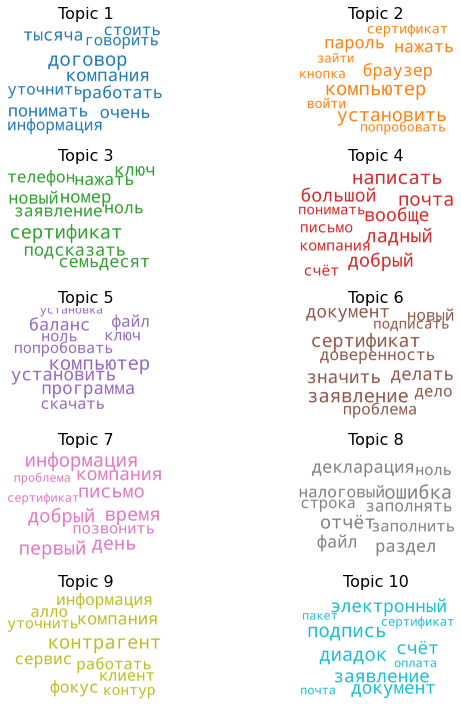

In [70]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=gensim.parsing.preprocessing.STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model_tfidf.show_topics(formatted=False)
fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [86]:
a = [4,5,6,7,8,9,10,11,12]
b = [0.42852709561482855,
0.4061079514206618,
0.42477091925324845,
0.4100431759917885,
0.40432474621570713,
0.39804716648613475,
0.4044004949439688,
0.4150855143217754,
0.44035528162713616]
c = [-9.359328362500921,
-9.375686576239701,
-9.4186893680891,
-9.467755879051227,
-9.512417276759816,
-9.491687492955162,
-9.508804498950996,
-9.551201264469292,
-9.614351540713516]

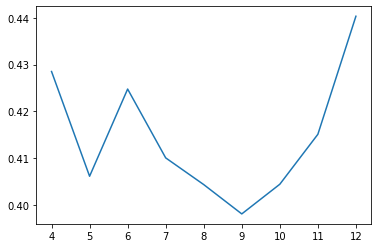

In [83]:
plt.plot(a,b)

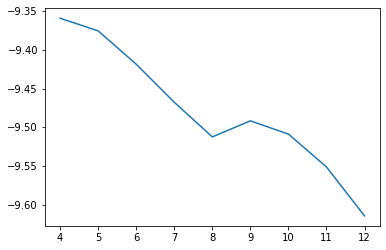

In [88]:
plt.plot(a,c)